In [13]:
# imports
import kagglehub
import numpy as np
import pandas as pd

# scikit-learn stuff
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


# download the dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("path to dataset files:", path)

path to dataset files: /home/tygo/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [14]:
import pandas as pd

# Trying to get a better sense of the data
csv_path = path + '/creditcard.csv'
df = pd.read_csv(csv_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,2.238554e-15,1.724421e-15,-1.245415e-15,8.238900e-16,1.213481e-15,4.866699e-15,1.436219e-15,-3.768179e-16,9.707851e-16,1.036249e-15,6.418678e-16,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [16]:
# split the dataset into training and test, use SMOTE since the dataset is imbalanced

X = df.iloc[:, :30] # all rows, first 30 columns
y = df.iloc[:, 30]  # all rows, last column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [17]:
# define the model and fit it on the training data
from sklearn.linear_model import RidgeClassifier

rc = RidgeClassifier(alpha=1, solver='saga') # decided on saga for the large number of features and samples
clf = rc.fit(X_train_res, y_train_res)
clf.score(X_test, y_test)


/home/tygo/Code/fraud-detection/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9971325913181888

So, this score is good, but too good to be true without much work. I used SMOTE to balance the dataset, which was a good choice I believe, but the choice of model could be slightly better. Models like random forest, XGBoost, or a NN may capture non-linear patterns better. Additionally, accuracy is not the only measure of performance, especially on such an imbalanced dataset. 

The next step is to use better evaluation metrics. Going to fit two other models, and display more informative metrics like precision, recall, and F1-score for the minority class.

In [18]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.35      0.76      0.48       147

    accuracy                           1.00     85443
   macro avg       0.67      0.88      0.74     85443
weighted avg       1.00      1.00      1.00     85443



In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[85087,   209],
       [   36,   111]])

Looking at the results, the model actually fails about 25% of the fraudulent cases. With only a 35% precision, which could be costly in something fragile like fraud detection. 

Trying a random forest classifier:

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_res, y_train_res)
rf_clf.score(X_test, y_test)

0.9995201479348805

In [21]:
y_rf_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.90      0.82      0.85       147

    accuracy                           1.00     85443
   macro avg       0.95      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Pretty good results,  can see that 90% of cases that were classified as fraud were indeed fraudulent cases, but a slightly problematic recall of 82%. Now I want to try a neural net trained on the SMOTE dataset. 

In [22]:
# had to use tf-nightly since this venv is on python 3.13
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import classification_report

In [23]:
n_inputs = X_train_res.shape[1]

smote_model = Sequential([
    Dense(128, input_shape=(n_inputs,), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/home/tygo/Code/fraud-detection/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-12 19:30:12.821342: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [24]:
smote_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

smote_model.fit(X_train_res, y_train_res,
                epochs=20,
                batch_size=64,
                validation_split=0.2,
                shuffle=True,
                verbose=1)

Epoch 1/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7365 - loss: 0.5011 - val_accuracy: 0.7530 - val_loss: 0.6894
Epoch 2/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8555 - loss: 0.2960 - val_accuracy: 0.9801 - val_loss: 0.0411
Epoch 3/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8648 - loss: 0.2760 - val_accuracy: 0.9881 - val_loss: 0.0303
Epoch 4/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8648 - loss: 0.2743 - val_accuracy: 0.8664 - val_loss: 0.3254
Epoch 5/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8677 - loss: 0.2649 - val_accuracy: 0.9563 - val_loss: 0.0740
Epoch 6/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8693 - loss: 0.2600 - val_accuracy: 0.9494 - val_loss: 0.0838
Epoch 7/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8715 - loss: 0.2596 - val_accuracy: 0.9506 - val_loss: 0.0770
Epoch 8/20
4976/4976 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.8746 - loss: 0

In [25]:
y_pred_prob = smote_model.predict(X_test, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.67      0.83      0.74       147

    accuracy                           1.00     85443
   macro avg       0.84      0.91      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [27]:
# Trying to scale the data to improve performance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

smote_model.fit(X_train_res_scaled, y_train_res, 
                epochs=20,
                batch_size=32,
                validation_split=0.2,
                verbose=1)

Epoch 1/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9821 - loss: 0.0555 - val_accuracy: 0.9956 - val_loss: 0.0118
Epoch 2/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9932 - loss: 0.0205 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 3/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9951 - loss: 0.0151 - val_accuracy: 0.9986 - val_loss: 0.0048
Epoch 4/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9954 - loss: 0.0139 - val_accuracy: 0.9991 - val_loss: 0.0031
Epoch 5/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9966 - loss: 0.0113 - val_accuracy: 0.9999 - val_loss: 9.2155e-04
Epoch 6/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 7/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9973 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 7.3611e-04
Epoch 8/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9974 -

In [28]:
y_pred_prob_scaled = smote_model.predict(X_test_scaled, verbose=1)
y_pred = (y_pred_prob_scaled > 0.5).astype(int)
print(classification_report(y_test, y_pred))

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.53      0.84      0.65       147

    accuracy                           1.00     85443
   macro avg       0.76      0.92      0.82     85443
weighted avg       1.00      1.00      1.00     85443



In [32]:
# Now try balancing the loss to penalize false negatives
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_dict = dict(enumerate(class_weights))
smote_model.fit(X_train_res_scaled, y_train_res,
                epochs=20,
                batch_size=32,
                validation_split=0.2,
                class_weight=class_weights_dict,
                verbose=1)

Epoch 1/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 5.5418e-04
Epoch 2/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9998 - val_loss: 7.3029e-04
Epoch 3/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.9989 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 2.9078e-04
Epoch 4/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - accuracy: 0.9988 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 2.0713e-04
Epoch 5/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.9988 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 4.5380e-04
Epoch 6/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 3.9350e-04
Epoch 7/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 2.8346e-04
Epoch 8/20
9951/9951 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step 

In [33]:
y_pred_prob = smote_model.predict(X_test_scaled, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.82      0.82      0.82       147

    accuracy                           1.00     85443
   macro avg       0.91      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



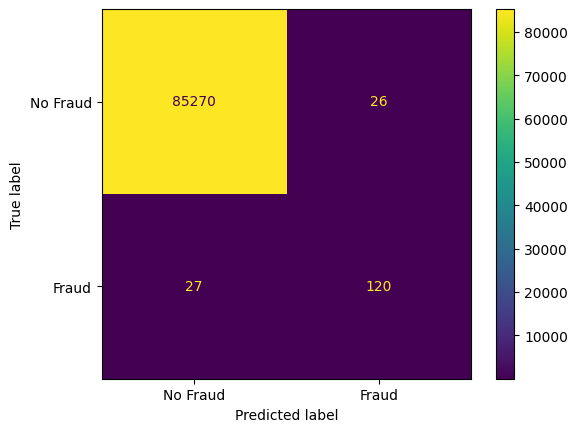

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

smote_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(smote_matrix, display_labels=['No Fraud', 'Fraud'])
disp.plot()
plt.show()